#COLAB_LINK

In [ ]:
Google_colab_link = "https://colab.research.google.com/drive/1F3k-6fOUSzV-grNc5XJEAk1xg7ZaMguj?usp=sharing"

# Download the Dataset from kaggle

In [1]:
!pip install opendatasets

In [4]:
import opendatasets as od
datasets = "https://www.kaggle.com/competitions/fruit-classification/data"
od.download(datasets)

Skipping, found downloaded files in "./fruit-classification" (use force=True to force download)


In [5]:
import pandas as pd

In [6]:
df_test = pd.read_csv("/content/fruit-classification/sample_submission.csv")


In [7]:
df_train = pd.read_csv("/content/fruit-classification/train.csv")

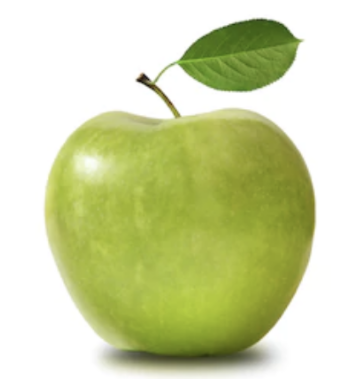

In [8]:
from PIL import Image
import os
import matplotlib.pyplot as plt

# Image folder path
image_folder = "/content/fruit-classification/train/train"

# Example: load the first image
first_image_name = df_train.loc[114, 'Id']
img_path = os.path.join(image_folder, first_image_name)

# Load the image
image = Image.open(img_path)
plt.imshow(image)
plt.axis('off')
plt.show()

# Fruit Classification - project


In [9]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [10]:
# Define constants
TRAIN_CSV_PATH = '/content/fruit-classification/train.csv'
TRAIN_IMG_DIR = '/content/fruit-classification/train/train'
TEST_IMG_DIR = '/content/fruit-classification/test/test'
BATCH_SIZE = 32
SEED = 42
VALIDATION_SPLIT = 0.2

In [11]:
# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

In [12]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [13]:
# Define the transformation pipeline
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
# Class for the training and validation datasets (with labels)
class FruitDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

        # Create a label mapping for classification
        self.classes = ['fresh_apple', 'fresh_banana', 'fresh_orange',
                        'rotten_apple', 'rotten_banana', 'rotten_orange']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['Id']
        label = self.df.iloc[idx]['Label']
        img_path = os.path.join(self.img_dir, img_name)

        # Handle both PNG and JPEG files with RGBA
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Convert text label to numeric index
        label_idx = self.class_to_idx[label]

        return image, label_idx

In [16]:
# Class for the test dataset (without labels)
class TestFruitDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # Handle both PNG and JPEG files with RGBA
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_name

In [17]:
def create_dataloaders():
    # Read the training data CSV
    train_df = pd.read_csv(TRAIN_CSV_PATH)

    # Split into train and validation sets
    train_df, val_df = train_test_split(
        train_df, test_size=VALIDATION_SPLIT, random_state=SEED,
        stratify=train_df['Label']  # Stratify to maintain class distribution
    )

    # Create datasets
    train_dataset = FruitDataset(train_df, TRAIN_IMG_DIR, transform=train_transforms)
    val_dataset = FruitDataset(val_df, TRAIN_IMG_DIR, transform=val_test_transforms)
    test_dataset = TestFruitDataset(TEST_IMG_DIR, transform=val_test_transforms)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4
    )

    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
    )

    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
    )

    return train_loader, val_loader, test_loader, train_dataset.classes

In [18]:
train_loader, val_loader, test_loader, classes = create_dataloaders()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [19]:
#  train_dataset.classes
classes

['fresh_apple',
 'fresh_banana',
 'fresh_orange',
 'rotten_apple',
 'rotten_banana',
 'rotten_orange']

# ResNet18 - Pretrained model

In [20]:
import torch.hub

Resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


In [21]:
Resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Define own fc

In [22]:
import torch.nn as nn
Resnet18.fc = nn.Sequential(
    nn.Linear(512, 120),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(120, 10)
)

In [23]:
Resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
for param in Resnet18.parameters():
        param.requires_grad = False
for param in Resnet18.fc.parameters():
        param.requires_grad = True

In [25]:
Resnet18 = Resnet18.to(device)

# Training

In [26]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Resnet18.parameters(), lr=0.001)

In [28]:
learning_rate = 0.0001
epochs = 25

In [29]:
# training loop

for epoch in range(epochs):
    running_loss = 0.0

    for Ids, labels in train_loader:
        Ids, labels = Ids.to(device), labels.to(device)

        outputs = Resnet18(Ids)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


    avg_Loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_Loss:.4f}")

    Resnet18.eval()

    with torch.no_grad():
      correct = 0
      total = 0
      for Ids , labels in val_loader:

        Ids , labels = Ids.to(device) , labels.to(device)

        outputs = Resnet18(Ids)
        _, predicted = torch.max(outputs , 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


      print("accuracy : ",correct / len(val_loader.dataset))


Epoch [1/25], Loss: 1.2428
accuracy :  0.9245283018867925
Epoch [2/25], Loss: 0.3447
accuracy :  0.9433962264150944
Epoch [3/25], Loss: 0.1854
accuracy :  0.9481132075471698
Epoch [4/25], Loss: 0.1295
accuracy :  0.9481132075471698
Epoch [5/25], Loss: 0.1012
accuracy :  0.9433962264150944
Epoch [6/25], Loss: 0.0996
accuracy :  0.9622641509433962
Epoch [7/25], Loss: 0.0834
accuracy :  0.9622641509433962
Epoch [8/25], Loss: 0.0645
accuracy :  0.9622641509433962
Epoch [9/25], Loss: 0.0524
accuracy :  0.9575471698113207
Epoch [10/25], Loss: 0.0518
accuracy :  0.9575471698113207
Epoch [11/25], Loss: 0.0487
accuracy :  0.9669811320754716
Epoch [12/25], Loss: 0.0443
accuracy :  0.9622641509433962
Epoch [13/25], Loss: 0.0483
accuracy :  0.9716981132075472
Epoch [14/25], Loss: 0.0346
accuracy :  0.9622641509433962
Epoch [15/25], Loss: 0.0261
accuracy :  0.9669811320754716
Epoch [16/25], Loss: 0.0300
accuracy :  0.9575471698113207
Epoch [17/25], Loss: 0.0291
accuracy :  0.9716981132075472
Epoch 

In [30]:
import pickle

In [31]:
pickle.dump(Resnet18,open('Resnet18_model.pkl','wb'))

In [63]:
predictions  = []
classes = ['fresh_apple', 'fresh_banana', 'fresh_orange',
                        'rotten_apple', 'rotten_banana', 'rotten_orange']
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

# Reverse mapping
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

# Example: get class name from index
index = 3
print(idx_to_class[1])


fresh_banana


In [69]:
import pandas as pd

predictions = []  # Store the final list of predictions

with torch.no_grad():
    for Ids, labels in test_loader:
        Ids = Ids.to(device)

        outputs = Resnet18(Ids)
        _, predicted = torch.max(outputs, 1)

        # For each item in the batch
        for filename, pred in zip(labels, predicted):
            # Append (filename, predicted class) to the predictions list
            predictions.append((filename, idx_to_class[pred.item()]))

# Create DataFrame with the predictions
df = pd.DataFrame(predictions, columns=["Label", "Predicted"])

# Save to CSV
df.to_csv("Submission_testdata.csv", index=False)

print("CSV file 'Submission_testdata.csv' created successfully!")


CSV file 'Submission_testdata.csv' created successfully!
